In [1]:
import os as os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split



import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D,Dropout,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


In [2]:
# accsess the data files and dir
cancer_rays_dir     = os.listdir("C:/S/programming/AI/Project_2/pythonProject/archive_breast_c/archive_breast_cancer/") 
all_rays_dir        = "all_rays_dir"  # is this path we will put all the images
cancer_rays_dir_str ="C:/S/programming/AI/Project_2/pythonProject/archive_breast_c/archive_breast_cancer/"

In [3]:
#print(cancer_rays_dir)
#print(len(cancer_rays_dir)) 

In [4]:
#os.mkdir(all_rays_dir)


In [5]:
#all_rays_dir_lst = os.listdir('./all_rays_dir') 

In [6]:
#Here we will move the images, but by adding a small part in their path, which indicates that they are negative or positive
#for patient in cancer_rays_dir:   
    #path_0 = cancer_rays_dir_str + str(patient) + '/0'
    #path_1 = cancer_rays_dir_str + str(patient) + '/1'
    #file_list_0 = os.listdir(path_0)   
    #file_list_1 = os.listdir(path_1)
    #for fname in file_list_0:
            #src = os.path.join(path_0, fname)
            #dst = os.path.join(all_rays_dir, fname)
            #shutil.copyfile(src, dst)
    #for fname in file_list_1:
        #src = os.path.join(path_1, fname)
        #dst = os.path.join(all_rays_dir, fname)
        #shutil.copyfile(src, dst)

In [7]:
all_rays_dir_lst = os.listdir('./all_rays_dir') 
#len(all_rays_dir_lst)

##### Now we have 277,524 images, what a number!

In [8]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data.head()


image_id
0  10253_idx5_x1001_y1001_class0.png
1  10253_idx5_x1001_y1051_class0.png
2  10253_idx5_x1001_y1101_class0.png
3  10253_idx5_x1001_y1151_class0.png
4  10253_idx5_x1001_y1201_class0.png

In [9]:
#Based on the addition that we added earlier in the path, we divide the data
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head(10)

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0
5  10253_idx5_x1001_y1251_class0.png      0
6  10253_idx5_x1001_y1301_class0.png      0
7  10253_idx5_x1001_y1351_class0.png      0
8  10253_idx5_x1001_y1501_class0.png      0
9  10253_idx5_x1001_y1551_class0.png      0

In [10]:
def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    patient_id = a[0]
    
    return patient_id
data['patient_id'] = data['image_id'].apply(extract_patient_id)
data.head()

image_id target patient_id
0  10253_idx5_x1001_y1001_class0.png      0      10253
1  10253_idx5_x1001_y1051_class0.png      0      10253
2  10253_idx5_x1001_y1101_class0.png      0      10253
3  10253_idx5_x1001_y1151_class0.png      0      10253
4  10253_idx5_x1001_y1201_class0.png      0      10253

In [11]:
data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

> # Exploratory Data Analysis

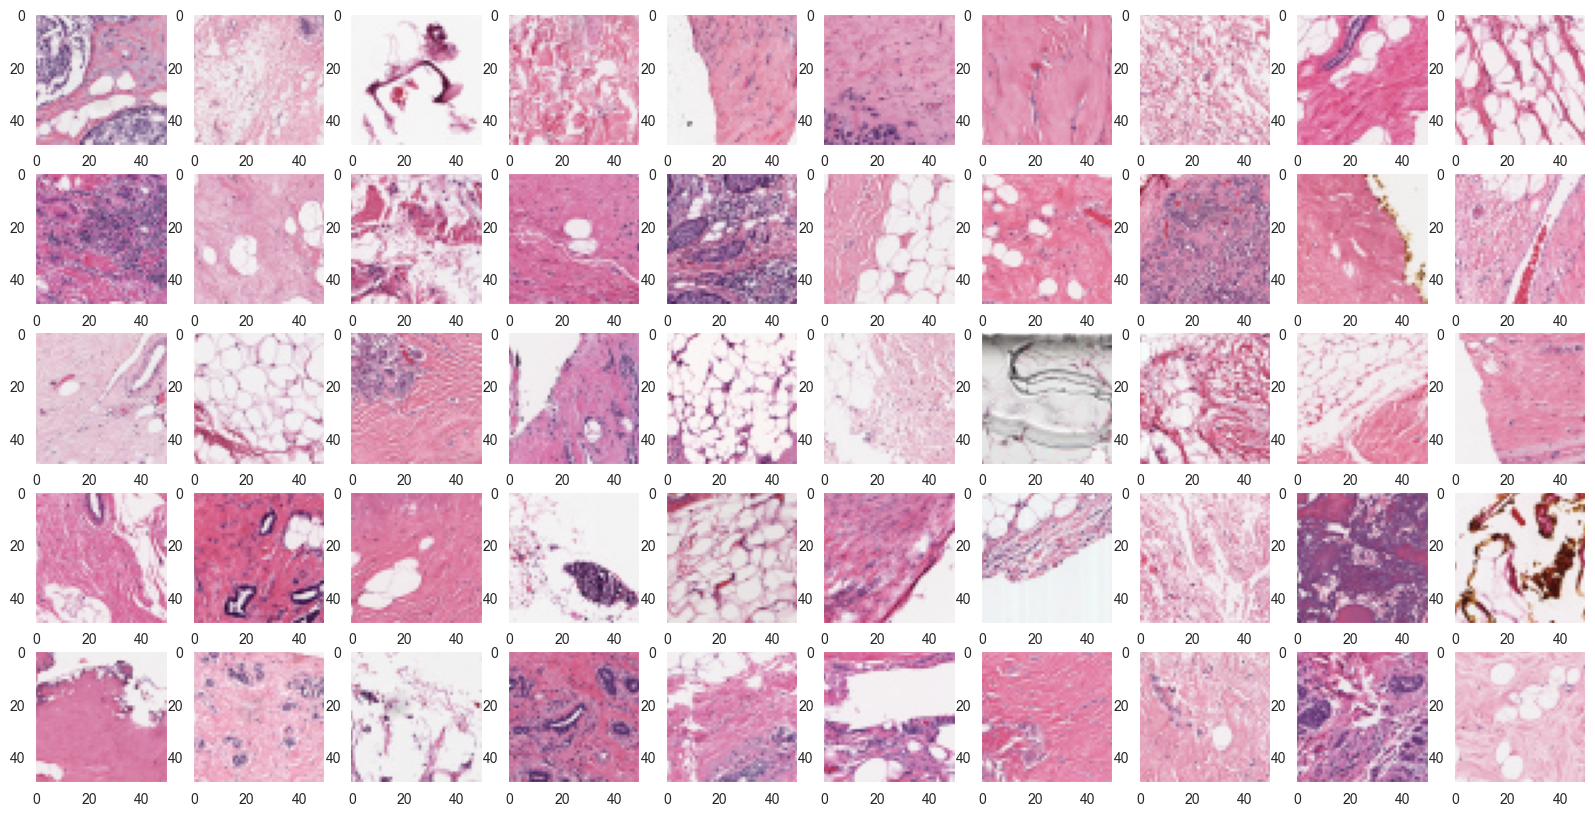

In [12]:
data.target = data.target.astype(int)
fig, ax = plt.subplots(5,10,figsize=(20,10))
pos_selection = np.random.choice(data[data.target ==1].index, size=50, replace=False,)
neg_selection = np.random.choice(data[data.target ==0].index, size=50, replace=False,)
for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)




### Insights
- Most of the mammograms are light pink, but there are some dark ones too

# Cancer patches:

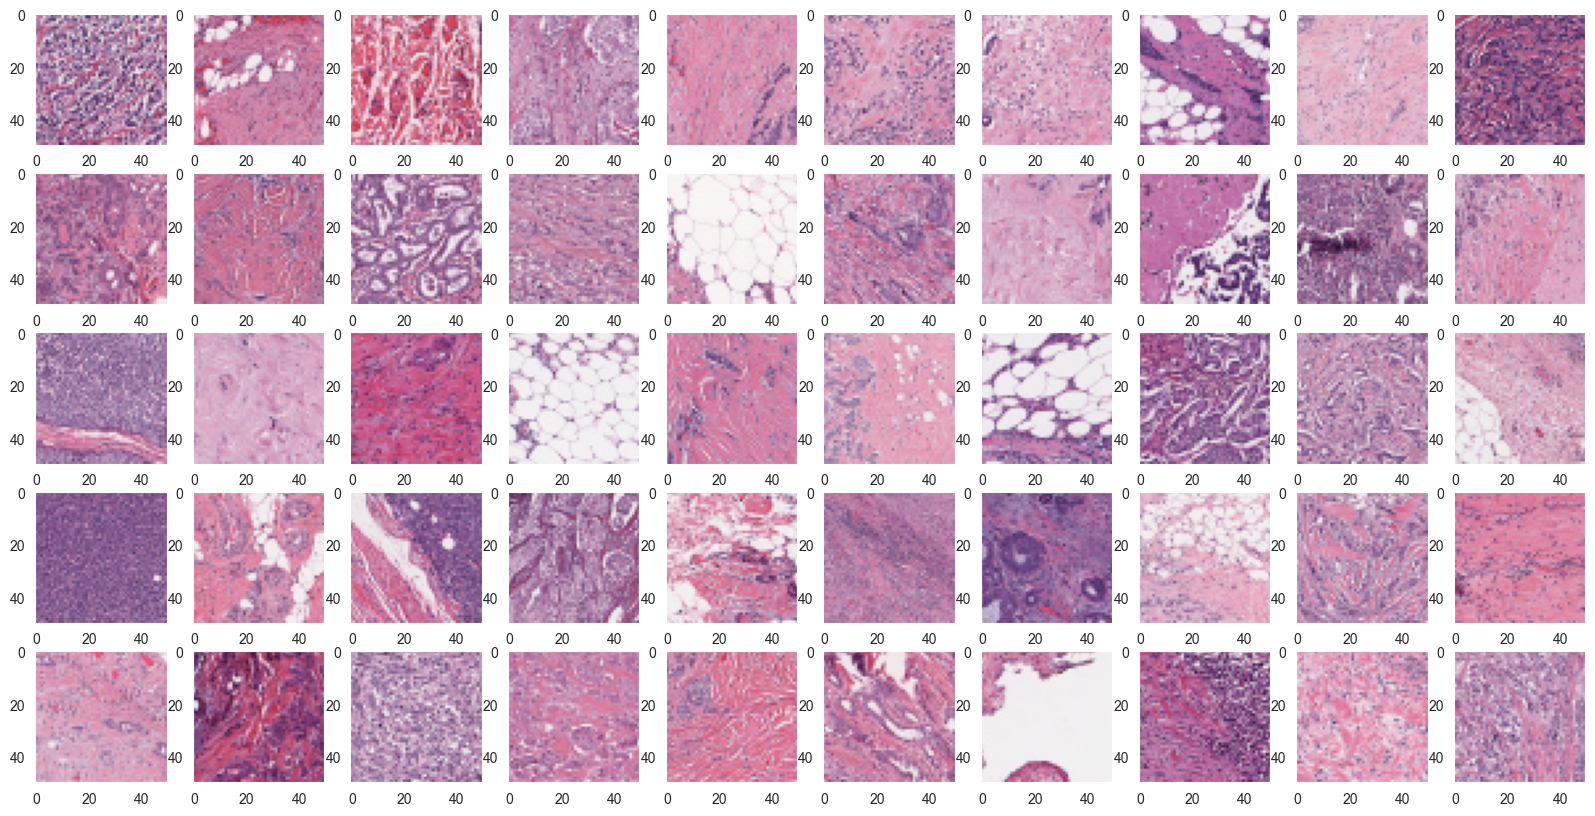

In [13]:
fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)


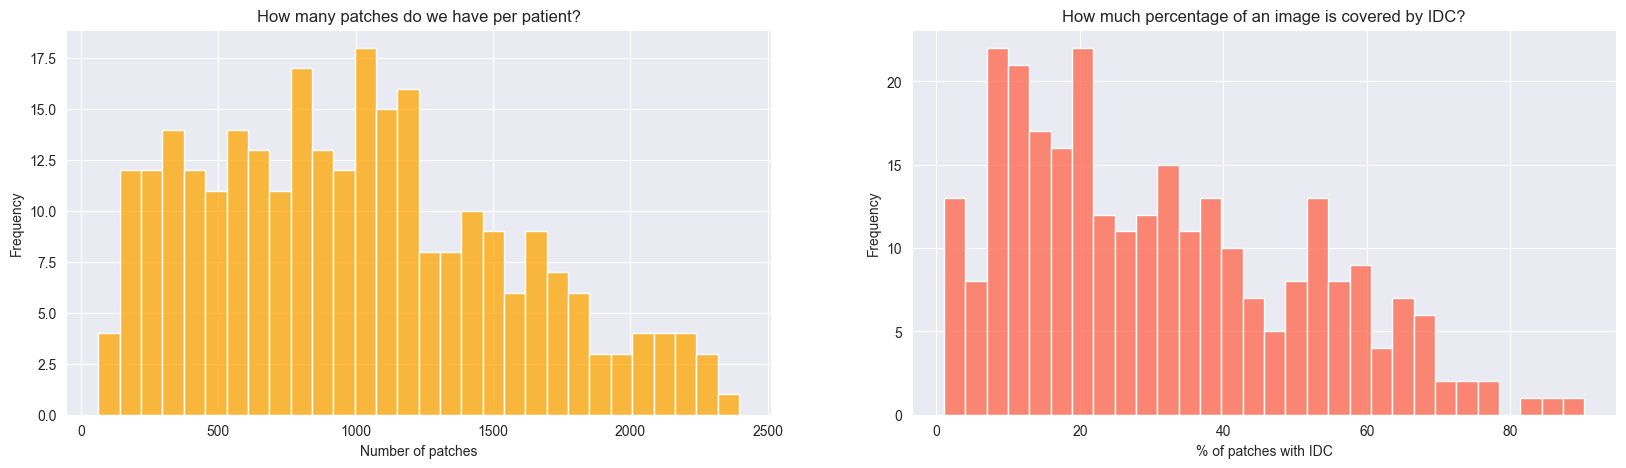

In [14]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.histplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.histplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
#sns.countplot(data.target, hue="cancer_perc" ,palette="Set2", ax=ax[2]);
#ax[2].set_xlabel("no(0) versus yes(1)")
#ax[2].set_title("How many patches show IDC?");

In [15]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = cancer_rays_dir_str + patient_id + "/" + cancer_id
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    return dataframe
def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df =pd.concat([df_0, df_1])
    return patient_df

In [16]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

x     y  target                                               path
0  1001  1001       0  C:/S/programming/AI/Project_2/pythonProject/ar...
1  1001  1051       0  C:/S/programming/AI/Project_2/pythonProject/ar...
2  1001  1101       0  C:/S/programming/AI/Project_2/pythonProject/ar...
3  1001  1151       0  C:/S/programming/AI/Project_2/pythonProject/ar...
4  1001  1201       0  C:/S/programming/AI/Project_2/pythonProject/ar...

### Well let's take a closer look at the shape of the patches and their distribution in each mammogram using Binary objective visualization for each tissue slice:

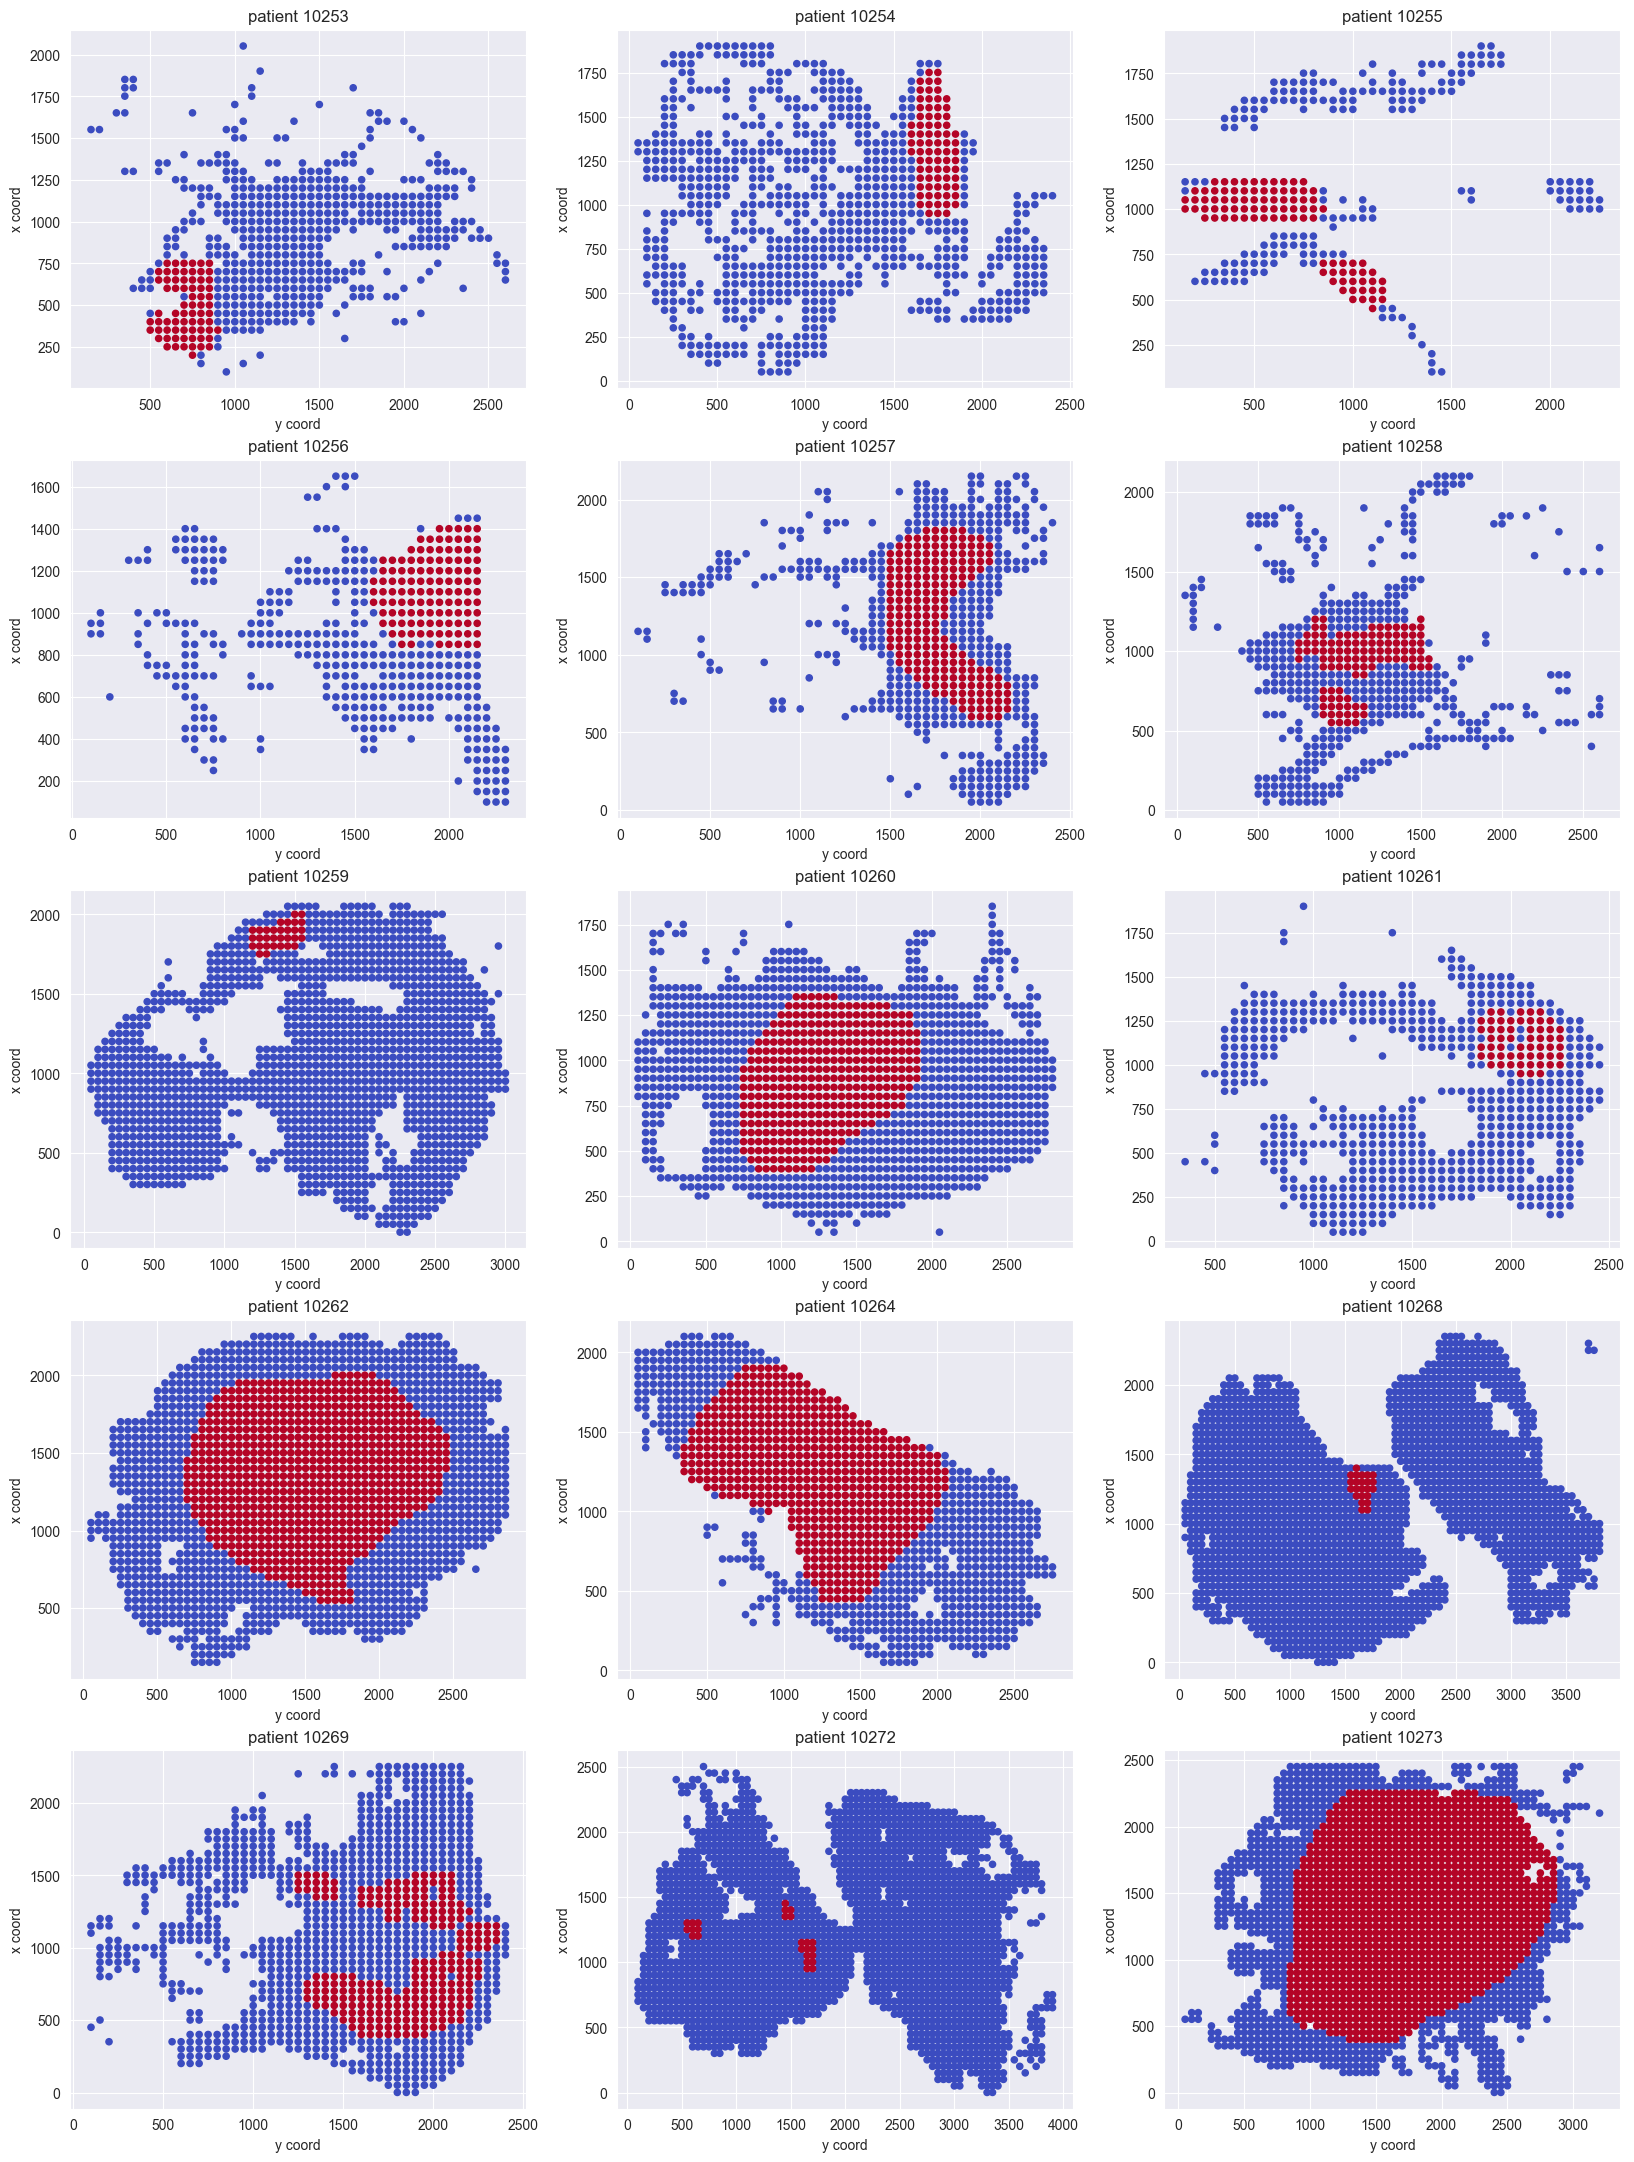

In [17]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

# Image Processing 

-  Apply some processing properties

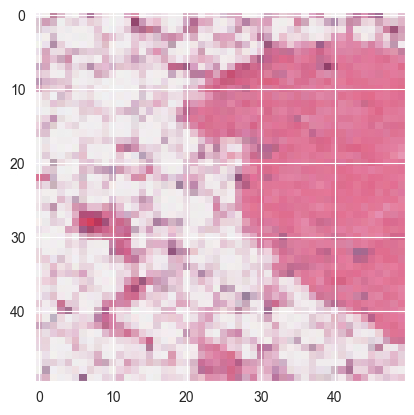

In [18]:
data.target = data.target.astype(int)
random_image_path = np.random.choice(data[data.target ==0].index, size=1, replace=False,)
path =os.path.join(all_rays_dir,data.loc[random_image_path[0], 'image_id'])
image = mpimg.imread(path)
plt.imshow(image)

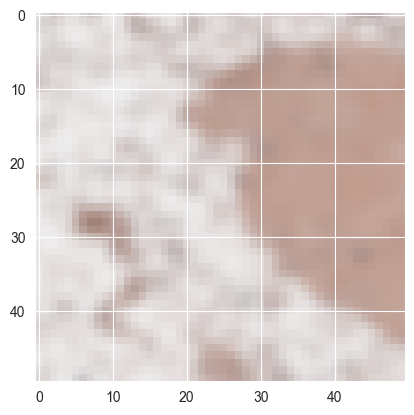

In [19]:
gaussian_image = gaussian(image)
plt.imshow(gaussian_image)

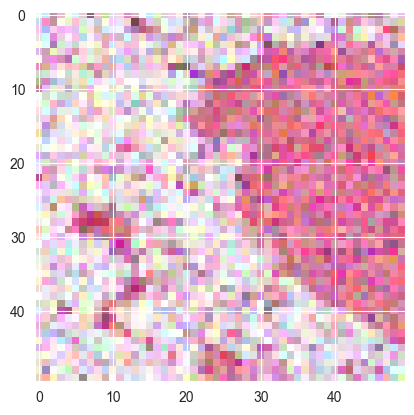

In [20]:
noise_image = random_noise(image)
plt.imshow(noise_image)

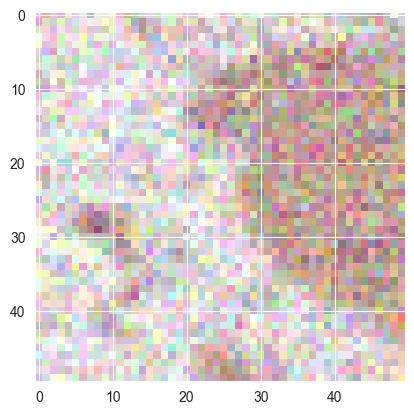

In [21]:
noise_gaussian_image = random_noise(gaussian_image)
plt.imshow(noise_gaussian_image)

-  Processing using (random_noise) function

In [22]:
#os.mkdir('image_processing') #We create a new file to process the data in
#os.mkdir('image_processing/noise_images')

In [23]:
#Here we take the image from the normal images folder, process it, and then save it in the new file
#for normal_image in all_rays_dir_lst :
   # path        = all_rays_dir+'/'+ normal_image
    #img         = mpimg.imread( path ,0)
    #noise_image = random_noise(img)
    #fname       = normal_image
    #new_path    = os.path.join('image_processing/noise_images',fname)
    #mpimg.imsave(new_path, noise_image)
    

In [24]:
#os.mkdir( 'image_processing/processd_data_train')
#os.mkdir( 'image_processing/processd_data_test')
#os.mkdir( 'image_processing/processd_data_train/zeros')
#os.mkdir( 'image_processing/processd_data_train/ones')
#os.mkdir( 'image_processing/processd_data_test/zeros')
#os.mkdir( 'image_processing/processd_data_test/ones')


In [25]:

processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
processd_data.head()

image_id
0  10253_idx5_x1001_y1001_class0.png
1  10253_idx5_x1001_y1051_class0.png
2  10253_idx5_x1001_y1101_class0.png
3  10253_idx5_x1001_y1151_class0.png
4  10253_idx5_x1001_y1201_class0.png

In [26]:
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0
5  10253_idx5_x1001_y1251_class0.png      0
6  10253_idx5_x1001_y1301_class0.png      0
7  10253_idx5_x1001_y1351_class0.png      0
8  10253_idx5_x1001_y1501_class0.png      0
9  10253_idx5_x1001_y1551_class0.png      0

In [27]:
processd_data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

In [28]:
y = processd_data['target']
processd_train, processd_test = train_test_split(processd_data, test_size=0.10, random_state=101, stratify=y)
processd_test_pls =processd_test.image_id
processd_train_pls =processd_train.image_id

In [29]:
processd_data.set_index('image_id', inplace=True)
#for image in processd_test_pls:
    #fname = image
    #target = processd_data.loc[image,'target']
    #if target == '0':
        #label = 'zeros'
    #if target == '1':
        #label = 'ones'
   # src = os.path.join(processd_lst_str, fname)
   # dst = os.path.join("image_processing/processd_data_test", label, fname)
    #shutil.copyfile(src, dst)


In [30]:
#for image in processd_train_pls:
   # fname  = image
   # target = processd_data.loc[image,'target']
    
   # if target == '0':
       # label = 'zeros'
   # if target == '1':
       # label = 'ones'
   # src = os.path.join(processd_lst_str, fname)
   # dst = os.path.join('image_processing/processd_data_train', label, fname)
   # shutil.copyfile(src, dst)

In [31]:
#print(len(os.listdir('image_processing/processd_data_train/zeros')))
#print(len(os.listdir('image_processing/processd_data_train/ones')))
#print(len(os.listdir('image_processing/processd_data_test/zeros')))
#print(len(os.listdir('image_processing/processd_data_test/ones')))

# Processing  and Normal test

-  the images we processed and the noraml are tested on the same model to see which the best in the accuracy

-  A small sample is taken for testing (20,000) images

### First: the processed images

In [32]:
processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0
5  10253_idx5_x1001_y1251_class0.png      0
6  10253_idx5_x1001_y1301_class0.png      0
7  10253_idx5_x1001_y1351_class0.png      0
8  10253_idx5_x1001_y1501_class0.png      0
9  10253_idx5_x1001_y1551_class0.png      0

In [33]:
#os.mkdir( 'image_processing/model_tst')
#os.mkdir( 'image_processing/model_tst/trainig')
#os.mkdir( 'image_processing/model_tst/testing')          
#os.mkdir( 'image_processing/model_tst/trainig/zeros')
#os.mkdir( 'image_processing/model_tst/trainig/ones')
#os.mkdir( 'image_processing/model_tst/testing/zeros')
#os.mkdir( 'image_processing/model_tst/testing/ones')

In [34]:
df_0 = processd_data[processd_data['target'] == '0'].sample(10000, random_state=101)
df_1 = processd_data[processd_data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
#for image in sts_train:
 #   fname  = image
  #  target = test_data.loc[image,'target']
    
   # if target == '0':
    #    label = 'zeros'
    #if target == '1':
     #   label = 'ones'
    #src = os.path.join(all_rays_dir, fname)
    #dst = os.path.join('image_processing/model_tst/trainig', label, fname)
    #shutil.copyfile(src, dst)
#for image in tst_test:
 #   fname  = image
  #  target = test_data.loc[image,'target']
    
   # if target == '0':
    #    label = 'zeros'
    #if target == '1':
     #   label = 'ones'
    #src = os.path.join(all_rays_dir, fname)
    #dst = os.path.join('image_processing/model_tst/testing', label, fname)
    #shutil.copyfile(src, dst)    


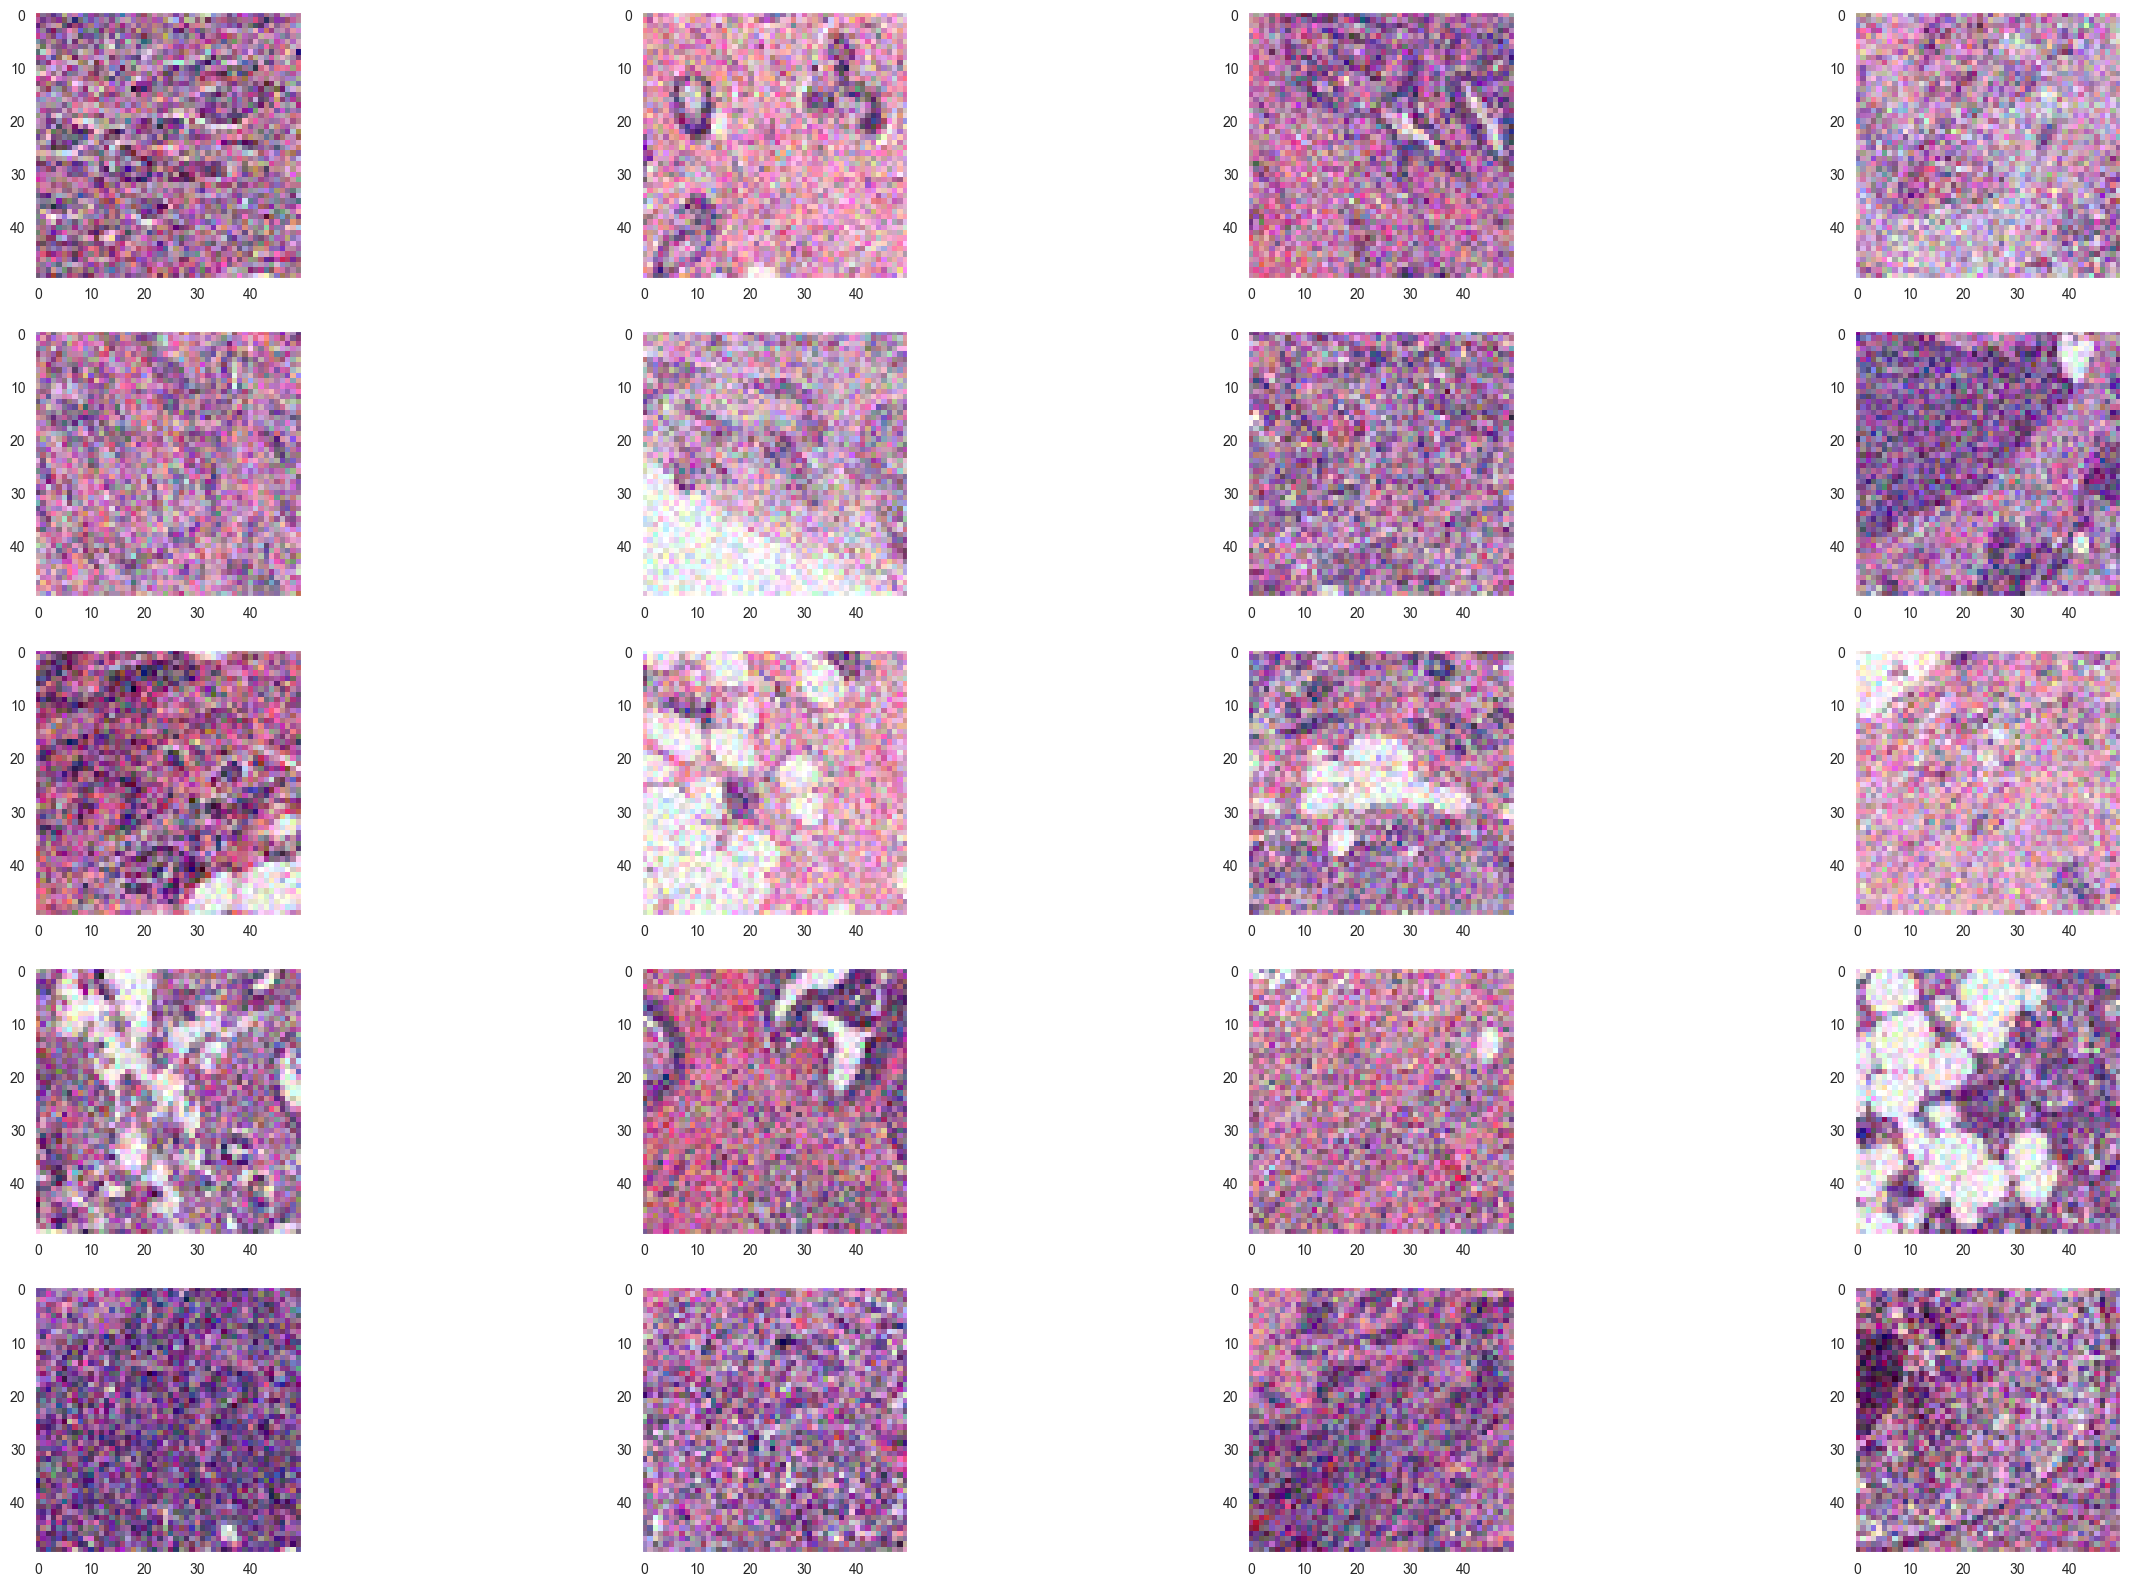

In [35]:
processd_data.target = processd_data.target.astype(int)
fig, ax = plt.subplots(5,4,figsize=(30,20))
pos_selection = np.random.choice(processd_data[processd_data.target==1].index.values, size=20, replace=False)
neg_selection = np.random.choice(processd_data[processd_data.target==0].index.values, size=20, replace=False)
for n in range(5):
    for m in range(4):
        idx = pos_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

- Here we show pictures of some of the processed carcinogenic images

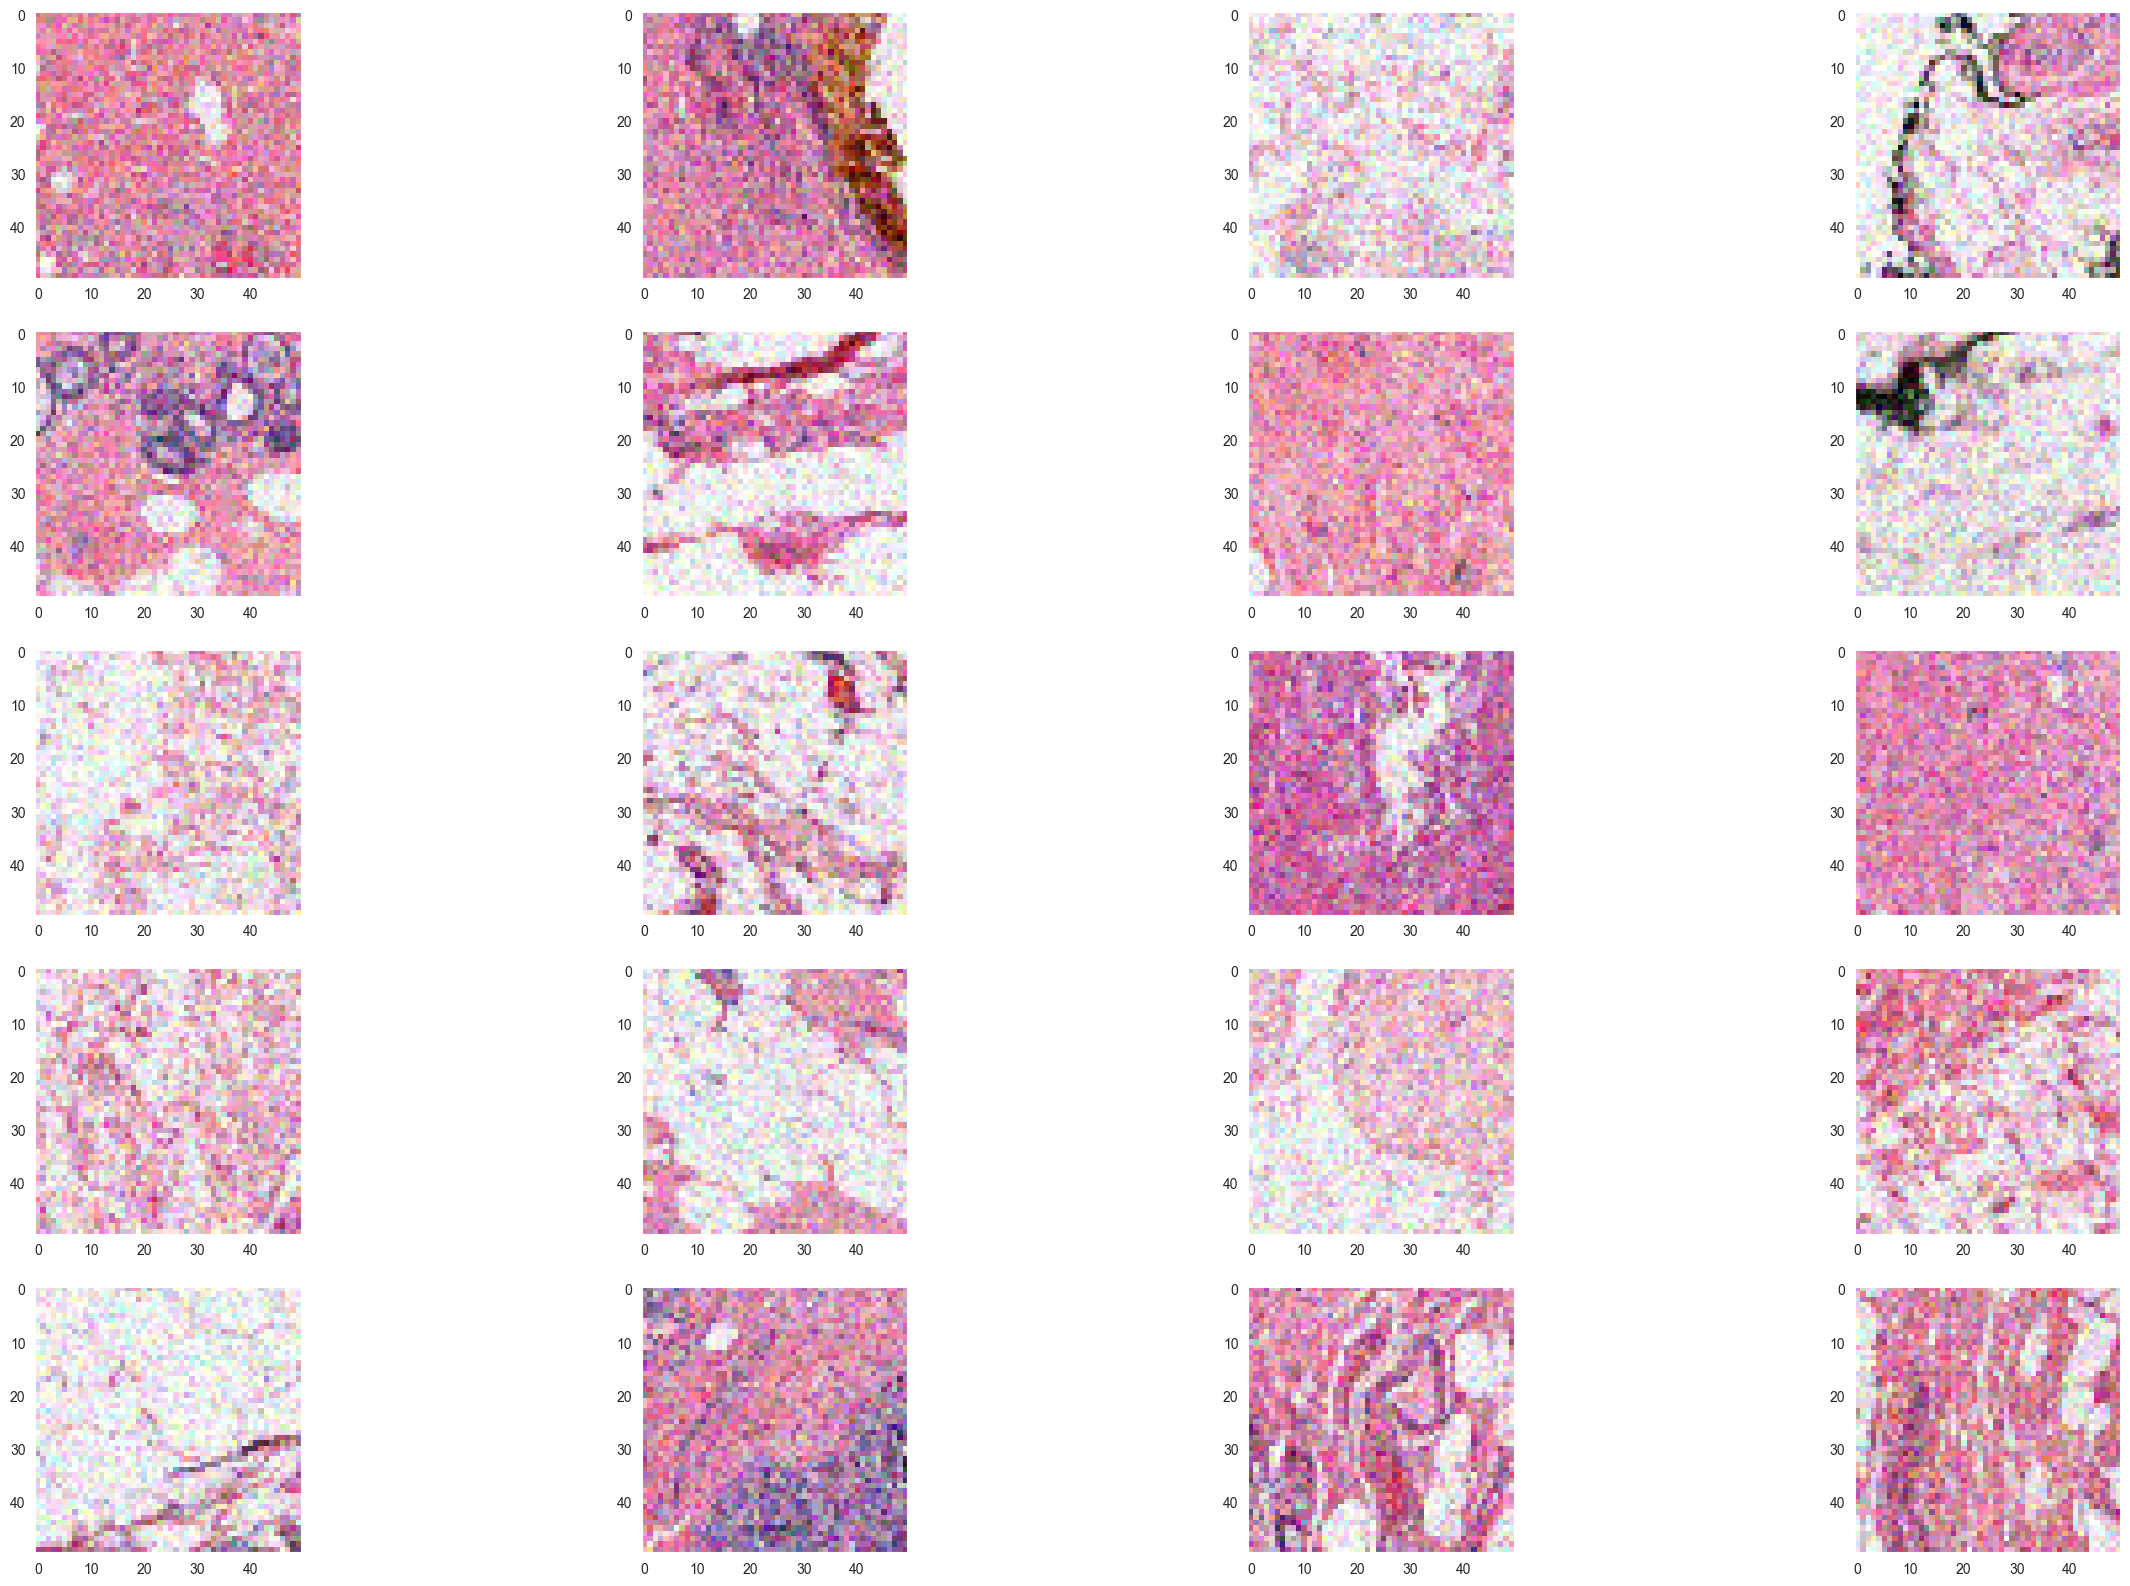

In [36]:
fig, ax = plt.subplots(5,4,figsize=(30,20))
for n in range(5):
    for m in range(4):
        idx = neg_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

- Here we show pictures of some of the normal images that have been processed

In [37]:
data_processd_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [38]:
my_model_im_processd =Sequential()
my_model_im_processd.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_processd.add(MaxPool2D(pool_size=(2,2)))


my_model_im_processd.add(Flatten())

my_model_im_processd.add(Dense(128,activation='relu'))

my_model_im_processd.add(Dense(2,activation='softmax'))

my_model_im_processd.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

C:\S\programming\AI\Project_2\pythonProject\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)
my_model_im_processd.fit(train_generation_processd,validation_data=test_generation_processd,epochs=50, verbose=1,callbacks=early_stop)

Epoch 1/50


C:\S\programming\AI\Project_2\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 457s 251ms/step - accuracy: 0.6239 - loss: 0.6607 - val_accuracy: 0.7530 - val_loss: 0.5434
Epoch 2/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 62s 34ms/step - accuracy: 0.7705 - loss: 0.5034 - val_accuracy: 0.7700 - val_loss: 0.5036
Epoch 3/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - accuracy: 0.7797 - loss: 0.4872 - val_accuracy: 0.7570 - val_loss: 0.5352
Epoch 4/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 57s 32ms/step - accuracy: 0.7785 - loss: 0.4879 - val_accuracy: 0.7565 - val_loss: 0.5173
Epoch 5/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - accuracy: 0.7828 - loss: 0.4826 - val_accuracy: 0.7710 - val_loss: 0.4910
Epoch 6/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 57s 32ms/step - accuracy: 0.7995 - loss: 0.4543 - val_accuracy: 0.7805 - val_loss: 0.4793
Epoch 7/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - accuracy: 0.8005 - loss: 0.4510 - val_accuracy: 0.7960 - val_loss: 0.4487
Epoch 8/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - accuracy: 0.8068 - loss: 0.

### Second: the normal images

In [40]:
#os.mkdir( 'image_processing/normal')
#os.mkdir( 'image_processing/normal/model_tst') 
#os.mkdir( 'image_processing/normal/model_tst/trainig')
#os.mkdir( 'image_processing/normal/model_tst/testing')
##os.mkdir( 'image_processing/normal/model_tst/trainig/zeros')
#os.mkdir( 'image_processing/normal/model_tst/trainig/ones')
#os.mkdir( 'image_processing/normal/model_tst/testing/zeros')
#os.mkdir( 'image_processing/normal/model_tst/testing/ones')

In [41]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data['target'] = data['image_id'].apply(extract_target)
df_0 = data[data['target'] == '0'].sample(10000, random_state=101)
df_1 = data[data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
#for image in sts_train:
 #   fname  = image
  #  target = test_data.loc[image,'target']
    
   # if target == '0':
    #    label = 'zeros'
    #if target == '1':
     #   label = 'ones'
    #src = os.path.join(all_rays_dir, fname)
    #dst = os.path.join('image_processing/normal/model_tst/trainig', label, fname)
    #shutil.copyfile(src, dst)
#for image in tst_test:
 #   fname  = image
  #  target = test_data.loc[image,'target']
    
   # if target == '0':
    #    label = 'zeros'
    #if target == '1':
     #   label = 'ones'
    #src = os.path.join(all_rays_dir, fname)
    #dst = os.path.join('image_processing/normal/model_tst/testing', label, fname)
    #shutil.copyfile(src, dst)    


In [42]:
data_normal_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [43]:
my_model_im_norm =Sequential()
my_model_im_norm.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_norm.add(MaxPool2D(pool_size=(2,2)))


my_model_im_norm.add(Flatten())

my_model_im_norm.add(Dense(128,activation='relu'))
my_model_im_norm.add(Dense(2,activation='softmax'))

my_model_im_norm.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

C:\S\programming\AI\Project_2\pythonProject\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)
my_model_im_processd.fit(train_generation_normal,validation_data=test_generation_normal,epochs=50, verbose=1,callbacks=early_stop)

Epoch 1/50


C:\S\programming\AI\Project_2\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 465s 258ms/step - accuracy: 0.8451 - loss: 0.3548 - val_accuracy: 0.7925 - val_loss: 0.5045
Epoch 2/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 57s 32ms/step - accuracy: 0.8564 - loss: 0.3378 - val_accuracy: 0.7775 - val_loss: 0.5440
Epoch 3/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - accuracy: 0.8549 - loss: 0.3398 - val_accuracy: 0.7855 - val_loss: 0.5616
Epoch 4/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - accuracy: 0.8683 - loss: 0.3067 - val_accuracy: 0.7830 - val_loss: 0.5869
Epoch 5/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - accuracy: 0.8806 - loss: 0.2851 - val_accuracy: 0.7840 - val_loss: 0.6304
Epoch 6/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - accuracy: 0.8884 - loss: 0.2660 - val_accuracy: 0.7765 - val_loss: 0.8139


In [45]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)
my_model_im_norm.fit(train_generation_normal,validation_data=test_generation_normal,epochs=50, verbose=1,callbacks=early_stop)

Epoch 1/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 59s 32ms/step - accuracy: 0.6837 - loss: 0.6471 - val_accuracy: 0.7855 - val_loss: 0.4743
Epoch 2/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - accuracy: 0.7755 - loss: 0.4943 - val_accuracy: 0.7600 - val_loss: 0.5010
Epoch 3/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - accuracy: 0.7800 - loss: 0.4807 - val_accuracy: 0.8025 - val_loss: 0.5051
Epoch 4/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - accuracy: 0.7855 - loss: 0.4754 - val_accuracy: 0.7855 - val_loss: 0.4683
Epoch 5/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - accuracy: 0.7906 - loss: 0.4643 - val_accuracy: 0.7800 - val_loss: 0.5010
Epoch 6/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - accuracy: 0.8027 - loss: 0.4415 - val_accuracy: 0.7985 - val_loss: 0.4482
Epoch 7/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 57s 32ms/step - accuracy: 0.8121 - loss: 0.4218 - val_accuracy: 0.7860 - val_loss: 0.4592
Epoch 8/50
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 57s 32ms/step - accuracy: 0.8234 -

## conclusion : Normal images are the best in modeling 

> # Modeling

# Data Spliting & Generation

In [46]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head()

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0

In [47]:
y = data['target']
data_train, data_test = train_test_split(data, test_size=0.10, random_state=101, stratify=y)

In [48]:
print(data_train.shape)
print(data_test.shape)

(249771, 2)
(27753, 2)


In [49]:
#os.mkdir( 'train_dir')
#os.mkdir('test_dir')

In [50]:
#os.mkdir( 'train_dir/zeros')
#os.mkdir( 'train_dir/ones')

#os.mkdir( 'test_dir/zeros')
#os.mkdir( 'test_dir/ones')


In [51]:
train = data_train.image_id
test  = data_test.image_id

In [52]:
data.set_index('image_id', inplace=True)
#for image in train:
 #   fname  = image
  #  target = data.loc[image,'target']
    
   # if target == '0':
    #    label = 'zeros'
    #if target == '1':
     #   label = 'ones'
    #src = os.path.join(all_rays_dir, fname)
    #dst = os.path.join('train_dir', label, fname)
    #shutil.copyfile(src, dst)

In [53]:
#for image in test:
 #   fname = image
  #  target = data.loc[image,'target']
   # if target == '0':
    #    label = 'zeros'
    #if target == '1':
     #   label = 'ones'
    #src = os.path.join(all_rays_dir, fname)
    #dst = os.path.join("test_dir", label, fname)
    #shutil.copyfile(src, dst)


In [54]:
#print('non-IDC train      =',len(os.listdir('train_dir/zeros')))
#print('IDC train          =',len(os.listdir('train_dir/ones')))
#print('non-IDC validation =',len(os.listdir('test_dir/zeros')))
#print('IDC validation     =',len(os.listdir('test_dir/ones')))

In [55]:
data_generation = ImageDataGenerator(rescale=1.0/255)

In [56]:
train_generation = data_generation.flow_from_directory(
                                        "train_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')
test_generation = data_generation.flow_from_directory(
                                        "test_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')



Found 249771 images belonging to 2 classes.
Found 27753 images belonging to 2 classes.


># Model design

In [57]:
my_model =Sequential()
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))

my_model.add(MaxPool2D(pool_size=(2,2)))
my_model.add(Conv2D(filters=64,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(MaxPool2D(pool_size=(2,2)))

my_model.add(Dropout(.3))

my_model.add(Flatten())

my_model.add(Dense(256,activation='relu'))

my_model.add(Dense(2,activation='softmax'))

my_model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

C:\S\programming\AI\Project_2\pythonProject\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
my_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,042 (777.51 KB)

 Trainable params: 199,042 (777.51 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

my_model.fit(train_generation,validation_data=test_generation,epochs=50, verbose=1,callbacks=early_stop, steps_per_epoch=1000)

Epoch 1/50


C:\S\programming\AI\Project_2\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1138s 1s/step - accuracy: 0.7091 - loss: 0.5728 - val_accuracy: 0.7601 - val_loss: 0.5321
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1088s 1s/step - accuracy: 0.7798 - loss: 0.4948 - val_accuracy: 0.8135 - val_loss: 0.4512
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1201s 1s/step - accuracy: 0.8001 - loss: 0.4602 - val_accuracy: 0.8141 - val_loss: 0.4210
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 594s 595ms/step - accuracy: 0.8138 - loss: 0.4342 - val_accuracy: 0.8081 - val_loss: 0.4267
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 667s 668ms/step - accuracy: 0.8179 - loss: 0.4335 - val_accuracy: 0.8138 - val_loss: 0.4401
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 643s 643ms/step - accuracy: 0.8135 - loss: 0.4276 - val_accuracy: 0.8238 - val_loss: 0.4192
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 564s 564ms/step - accuracy: 0.8151 - loss: 0.4283 - val_accuracy: 0.8298 - val_loss: 0.3964
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 650s 651ms/step - accuracy: 0.8211 - 

C:\Users\saish\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 617s 618ms/step - accuracy: 0.8329 - loss: 0.3893 - val_accuracy: 0.8345 - val_loss: 0.3760
Epoch 26/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 646s 644ms/step - accuracy: 0.8356 - loss: 0.3907 - val_accuracy: 0.8347 - val_loss: 0.3752
Epoch 27/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 884s 884ms/step - accuracy: 0.8369 - loss: 0.3802 - val_accuracy: 0.8436 - val_loss: 0.3694
Epoch 28/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 662s 663ms/step - accuracy: 0.8338 - loss: 0.3919 - val_accuracy: 0.8344 - val_loss: 0.3781
Epoch 29/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 637s 638ms/step - accuracy: 0.8290 - loss: 0.3922 - val_accuracy: 0.8276 - val_loss: 0.3988
Epoch 30/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 598s 599ms/step - accuracy: 0.8279 - loss: 0.4002 - val_accuracy: 0.8367 - val_loss: 0.3722
Epoch 31/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 624s 625ms/step - accuracy: 0.8310 - loss: 0.3894 - val_accuracy: 0.8390 - val_loss: 0.3882
Epoch 32/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 580s 581ms/step - accura

># Outputs and Outcomes

In [60]:
losse = pd.DataFrame(my_model.history.history)
losse.head()

accuracy      loss  val_accuracy  val_loss
0    0.7421  0.533517      0.760134  0.532115
1    0.7897  0.475386      0.813534  0.451241
2    0.8071  0.450310      0.814146  0.420960
3    0.8163  0.431096      0.808129  0.426715
4    0.8186  0.424458      0.813786  0.440078

<Axes: >

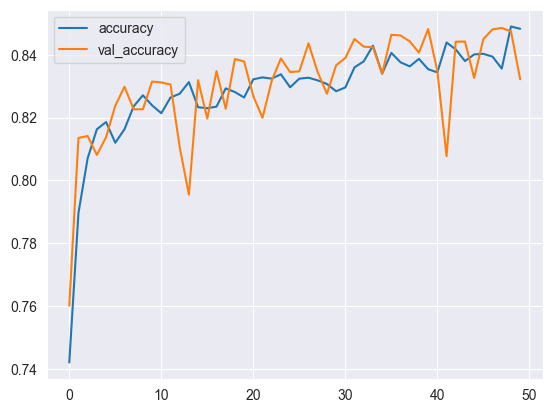

In [61]:
losse[['accuracy','val_accuracy']].plot()

<Axes: >

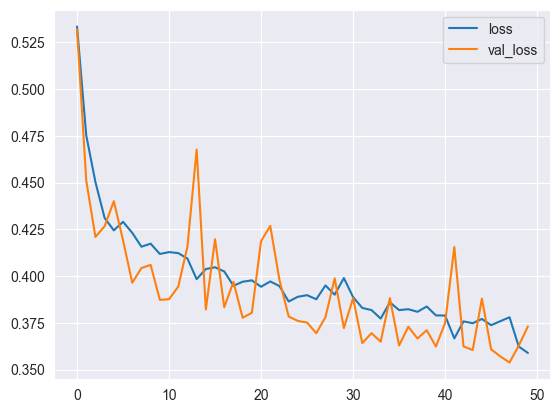

In [62]:
losse[['loss','val_loss']].plot()


In [63]:
val_loss, val_acc = \
my_model.evaluate(test_generation)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

2776/2776 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.8344 - loss: 0.3672
val_loss: 0.3731347620487213
val_acc: 0.8321983218193054


## model results :

- After several attempts, we made a good model design
- Our model have a good acc = 82%
- over fitting is so small 
- We're ready to create APIs

> # Save &Loaded Model

In [64]:
model_json = my_model.to_json()

In [65]:

with open("model.json", "w") as json_file:
    json_file.write(model_json)
my_model.save_weights("model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [66]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.weights.h5")
print("Loaded model from disk")
 
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


Loaded model from disk


> # APIs &  Web Localization

- we will use this class to connect the web app to the model

In [67]:
class Api_service :
    def __init__(self,img_file_path):
        self.img_file_path = img_file_path
    def prediction_function(self) :
        predict_generation = data_generation.flow_from_directory(
                                            self.img_file_path,
                                            target_size=(25,25),
                                            batch_size=10,
                                            class_mode='categorical')

        prediction = loaded_model.predict(predict_generation)
        has_cancer = 'The percentage of cancer : '+ str(round(prediction[0][0]*100,2)) + "%"
        has_no_cancer='Percentage of no cancer : ' + str(round(prediction[0][1]*100,2)) + '%'
        return has_cancer,has_no_cancer 


In [69]:
prediction = Api_service("image_processing/normal/model_tst/trainig")
x,y        = prediction.prediction_function()
print(x)
print(y)

Found 18000 images belonging to 2 classes.


C:\S\programming\AI\Project_2\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 519s 282ms/step
The percentage of cancer : 4.26%
Percentage of no cancer : 95.74%
